In [23]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from chainconsumer import ChainConsumer

In [4]:
# Load the cepheid and SNe data.
ceph = pd.read_csv('ceph.csv')
sne = pd.read_csv('sne.csv')

# Cut the rejected cepheids.
ceph_cut = ceph['flag'].str.contains('rej', na=False)
ceph = ceph[~ceph_cut]

# Preprocess the host galaxy names in the cepheid catalog.
def proc_ceph_host(x):
    if 'NIC' in x:
        return 'N4258'
    else:
        return 'N' + x[1:5]
    
ceph['host'] = ceph['host'].apply(proc_ceph_host)

# Preprocess the host galaxy names in the SNe catalog.
def proc_sne_host(x):
    return 'N' + x[4:8]
    
sne['host'] = sne['host'].apply(proc_sne_host)

In [7]:
with pm.Model() as model:
    # Set priors for the SNe host distance moduli.
    zp_hosts = {}
    for host in sne['host']:
        zp_hosts[host] = pm.Uniform('zp_%s' % host, lower=-100, upper=100)
    
    zp_hosts['N4258'] = pm.Uniform('zp_N4258', lower=-100, upper=100)

    # Priors for the remaining model parameters.
    b = pm.Uniform('b', lower=-100, upper=100)

    # Compute the predicted cepheid apparent magnitudes.
    zp_arr = pm.math.stack([zp_hosts[host] for host in ceph['host']])
    m_pred = (zp_arr - zp_hosts['N4258']) + zp_hosts['N4258'] + b * np.log10(ceph['period'])

    # Cepheid likelihood term.
    pm.Normal('m_cepheids', mu=m_pred, sigma=ceph['mag_err'], observed=ceph['mag'])
    
    # Run the sampler.
    trace = pm.sample(cores=16, tune=10000, draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [b, zp_N4258, zp_N1309, zp_N3021, zp_N3370, zp_N3982, zp_N4639, zp_N4536]


Sampling 16 chains for 10_000 tune and 10_000 draw iterations (160_000 + 160_000 draws total) took 170 seconds.
The acceptance probability does not match the target. It is 0.9066217918804463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6183351021074591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9028839694773043, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3197 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4438183966426697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7132747434306864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match 

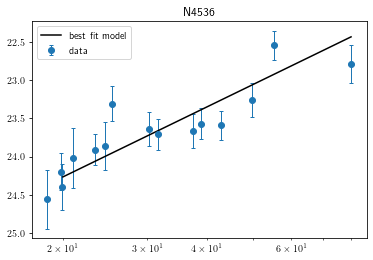

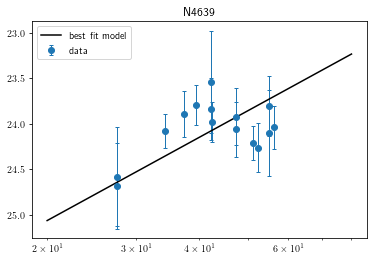

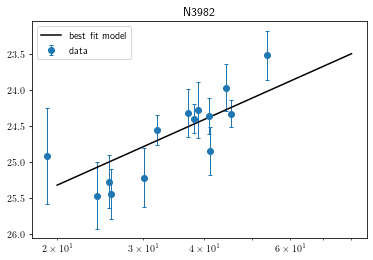

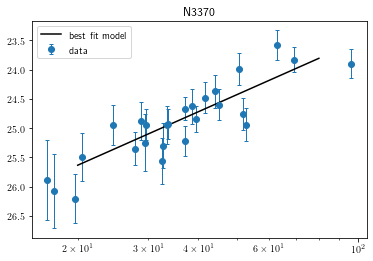

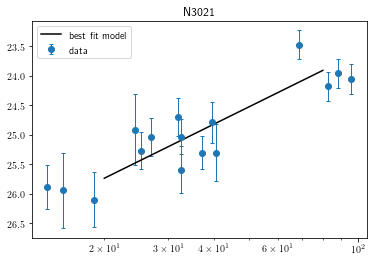

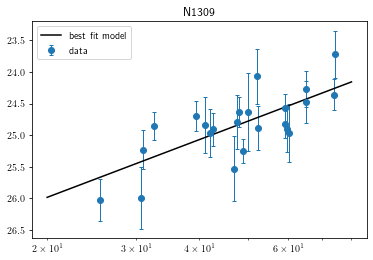

In [48]:
for host in sne['host']:
    zp = trace['zp_%s' % host].mean()
    b = trace['b'].mean()
    x = np.logspace(np.log10(20), np.log10(80), num=100, base=10)
    y = zp + b * np.log10(x)
    
    plt.figure()
    plt.title(host)
    mask = ceph['host']==host
    plt.errorbar(ceph['period'][mask], ceph['mag'][mask], yerr=ceph['mag_err'][mask], linewidth=0, elinewidth=1, capsize=2, marker="o", label='data')
    plt.plot(x, y, color='black', label='best fit model')
    plt.xscale('log')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.savefig("figures/P-L_"+host+".png", dpi=300)
    plt.plot()